# Análisis Exploratorio de Datos (EDA) - Amazon Sales Report

Este notebook tiene como objetivo realizar un Análisis Exploratorio de Datos (EDA) sobre el dataset **Amazon Sales Report**.  
Las metas principales son:
- Limpiar y preprocesar el dataset para garantizar consistencia.
- Obtener estadísticas descriptivas y detectar valores atípicos o inconsistentes.
- Generar nuevas variables que permitan un mejor análisis.
- Identificar patrones e insights relevantes para la operación de la tienda online.
- Exportar datasets preparados para herramientas de visualización como Tableau.

El análisis visual detallado se complementará en **Tableau**, mientras que en este documento se concentra la limpieza, análisis estadístico y hallazgos clave.

## Parámetros & Paths

Este módulo centraliza nombres de archivo y prioridades de columnas para que el resto del notebook sea configurable sin tocar cada celda. La idea es: si la fuente cambia (otro CSV, otras cabeceras), realizar los ajustes solo acá y todo el pipeline se adapta.

In [ ]:
RAW_PATH = "Amazon Sale Report.csv"
CLEAN_PATH = "amazon_cleaned_for_tableau.csv"

DATE_COL_PRIORITY = ["order_date","purchase_date","date","created_at"]
QTY_CANDIDATES = ["qty","quantity","order_quantity"]
AMOUNT_CANDIDATES = ["amount","item_total","total","item_amount"]
PRICE_CANDIDATES  = ["price","unit_price"]
STATUS_CANDIDATES = ["status","order_status","courier_status"]
ORDERID_CANDIDATES= ["order_id","order_item_id","order","id"]
B2B_CANDIDATES    = ["b2b"]
SKU_CANDIDATES    = ["sku"]
CAT_CANDIDATES    = ["category"]
PROMO_CANDIDATES  = ["promotion_ids","promotion_id","promo_id"]

DATEFIRST = False

## Setup (imports + helpers)

Este módulo carga librerías base y define funciones que se usan en todo el pipeline. La gracia es evitar repetir lógica frágil (p. ej., limpiar strings, detectar columnas, normalizar estados) y asegurar comportamientos consistentes.

Librerías importadas:
- os, re, json, datetime: utilidades del sistema, regex y manejo de fechas básicas.
- numpy (np), pandas (pd): columna vertebral para limpieza y análisis.
- matplotlib.pyplot (plt): gráficos rápidos para validar tendencias y distribuciones.

Helpers utilizados:

- slugify(s: str) -> str : Convierte nombres de columnas a snake_case limpio y estable:
- to_number(series: pd.Series) -> pd.Series : Fuerza una serie a numérica eliminando cualquier cosa que no sea dígitos, punto o signo menos.
- find_first(cols, candidates) : Busca la primera coincidencia de una lista de nombres candidatos dentro del set real de columnas.
- normalize_status(s: str) -> str : Estandariza el estado de la línea/pedido a un bucket consistente:
    - si contiene “cancel”, “refunded”, “returned” → not_fulfilled
    - si contiene “delivered”, “shipped”, “complete”, “fulfilled” → fulfilled
    - faltantes o irreconocibles → unknown o el valor original según convenga.

In [2]:
import os, re, json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def slugify(s: str) -> str:
    s = s.strip().lower()
    for ch in [" ", "/", "\\", "-", "(", ")", "[", "]", "{", "}", ".", ",", ";", ":", "|"]:
        s = s.replace(ch, "_")
    while "__" in s:
        s = s.replace("__", "_")
    return s.strip("_")

def to_number(series: pd.Series) -> pd.Series:
    return (series.astype(str)
            .str.replace(r"[^\d\.\-]", "", regex=True)
            .replace("", np.nan)
            .astype(float))

def find_first(cols, candidates):
    for cand in candidates:
        if cand in cols:
            return cand
    return None

def normalize_status(s: str) -> str:
    if pd.isna(s):
        return "unknown"
    s = str(s).lower()
    if any(k in s for k in ["cancel","refunded","returned","return"]):
        return "not_fulfilled"
    if any(k in s for k in ["delivered","shipped","complete","fulfilled"]):
        return "fulfilled"
    return s


## Carga de datos
Este módulo lee el CSV de forma tolerante a problemas comunes de archivos. La idea es traer los datos sin romper nada y, al mismo tiempo, dar alertas rápidas si algo no cierra.

Estrategia de carga:
- encodings_to_try = ["utf-8","latin-1","cp1252"] : Probamos tres codificaciones frecuentes en dumps comerciales:
    - UTF-8: estándar moderno.
    - latin-1 / cp1252: muy usados cuando hay acentos, símbolos de moneda (₹, €) o exportes desde Windows/Excel. Si una falla, pasamos a la siguiente. Guardamos el último error como last_err para reportarlo con claridad si ninguna funciona.

- pd.read_csv(..., low_memory=False)
Le pedimos a pandas que no fragmente la inferencia de tipos por chunks. Eso consume un poco más de RAM, pero evita que una misma columna termine con tipos inconsistentes (mitad object, mitad float).

In [3]:
encodings_to_try = ["utf-8","latin-1","cp1252"]
raw_df = None
for enc in encodings_to_try:
    try:
        raw_df = pd.read_csv(RAW_PATH, encoding=enc, low_memory=False)
        break
    except Exception as e:
        last_err = e
if raw_df is None:
    raise RuntimeError(f"No se pudo leer el CSV. Último error: {last_err}")

display(raw_df.head(5))
print("Shape:", raw_df.shape)


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


Shape: (128975, 24)


In [ ]:
# 1) ¿El separador está bien?
# print("Vista rápida de columnas:", list(raw_df.columns)[:10])

# 2) ¿Hay caracteres raros?
# print("Sample de texto crudo:", raw_df.astype(str).iloc[0].to_dict())

# 3) ¿Volumen esperado?
# print("Filas:", len(raw_df), "| Columnas:", raw_df.shape[1])

## Normalización & limpieza básica

Antes de tipificar o calcular métricas, dejamos la tabla en un estado consistente y predecible. Este módulo aplica cuatro cosas simples pero cruciales:

#### Estandarizar nombres de columnas (snake_case)
Usamos slugify para: pasar todo a minúsculas, reemplazar espacios y símbolos por _, colapsar dobles guiones bajos y recortar extremos.

Por qué? Porque evita errores por nombres “creativos” del CSV (“Order Id”, “Order-Id”, “Order(ID)”) y facilita seleccionar columnas sin sorpresas (df["order_id"] siempre funciona).

#### Eliminar columnas vacías y duplicados exactos
- dropna(axis=1, how="all"): quita columnas completamente nulas (ruido típico de exportes).
- drop_duplicates(): elimina filas idénticas.

Por qué? Porque reduce memoria y evita contar dos veces la misma línea.

#### Limpiar strings
Para columnas object aplicamos:
- astype(str).str.strip(): quita espacios de extremos (incluye tabs y saltos),
- .replace({"": np.nan, "nan": np.nan}): homogeneiza vacíos y strings literales "nan" a NaN.

Por qué? Porque un “vacío” con espacios o un "nan" textual no es NaN para pandas y rompe filtros/agrupaciones.

In [16]:
df = raw_df.copy()
df.columns = [slugify(c) for c in df.columns]
df = df.dropna(axis=1, how="all").drop_duplicates()

for c in df.columns:
    if df[c].dtype == "object":
        df[c] = df[c].astype(str).str.strip().replace({"": np.nan, "nan": np.nan})

print("Shape post-limpieza básica:", df.shape)
df.head(3)


Shape post-limpieza básica: (128975, 24)


,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,b2b,fulfilled_by,unnamed_22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN


## Tipificación (números & fechas)
Convertir columnas que “parecen números” a tipos numéricos reales y parsear solo las columnas que son fechas, sin tocar IDs ni claves de negocio.

#### Detección y coerción numérica (robusta)
Buscamos columnas “numéricas probables” con una heurística: si >70% de una muestra de valores matchea el patrón numérico (después de limpiar símbolos), la marcamos como candidata.
- Convertimos con to_number, que elimina todo salvo dígitos, punto y signo -, y devuelve float con NaN donde no se puede parsear.

En retail real, montos/cantidades vienen como texto con moneda, separadores de miles, espacios o incluso emojis. La coerción robusta evita que cálculos (sumas, medias) se rompan o silencien errores.

#### Parseo de fechas con “date-safe parsing”
Identificamos candidatas de fecha por nombre: columnas que contienen date o están listadas en DATE_COL_PRIORITY.
- Parseamos con pd.to_datetime(..., errors="coerce", infer_datetime_format=True, dayfirst=DATEFIRST).

No parseamos nada que no esté explícitamente marcado como fecha (ej.: nunca order_id).

In [5]:
numeric_candidates = []
for c in df.columns:
    sample = df[c].dropna().astype(str).head(200)
    if len(sample) == 0:
        continue
    pct_numeric_like = np.mean(sample.str.replace(r"[^\d\.\-]", "", regex=True)
                               .str.match(r"^\-?\d+(\.\d+)?$"))
    if pct_numeric_like > 0.7:
        numeric_candidates.append(c)

for c in numeric_candidates:
    try:
        df[c] = to_number(df[c])
    except Exception:
        pass

date_candidates = [c for c in df.columns if ("date" in c) or (c in DATE_COL_PRIORITY)]
for c in date_candidates:
    try:
        df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True, dayfirst=DATEFIRST)
    except Exception:
        pass

date_candidates, numeric_candidates[:10]


C:\Users\anton\AppData\Local\Temp\ipykernel_10136\1427428224.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True, dayfirst=DATEFIRST)
C:\Users\anton\AppData\Local\Temp\ipykernel_10136\1427428224.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True, dayfirst=DATEFIRST)


(['date'], ['index', 'style', 'asin', 'qty', 'amount', 'ship_postal_code'])

In [20]:
# Distribución de tipos post-coerción
df.dtypes.value_counts()


object     19
int64       2
float64     2
bool        1
Name: count, dtype: int64

In [21]:
# Fechas válidas
for c in [x for x in df.columns if 'date' in x]:
    print(c, df[c].min(), '→', df[c].max(), '| NaT%', df[c].isna().mean().round(3))

date 03-31-22 → 06-29-22 | NaT% 0.0


In [22]:
# Números sin textos
num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
df[num_cols].describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
index,128975.0,64487.000000,37232.019822,0.0,32243.5,64487.0,96730.5,128974.0
qty,128975.0,0.904431,0.313354,0.0,1.0,1.0,1.0,15.0
amount,121180.0,648.561465,281.211687,0.0,449.0,605.0,788.0,5584.0
ship_postal_code,128942.0,463966.236509,191476.764941,110001.0,382421.0,500033.0,600024.0,989898.0


## Features retail (status, revenue, tiempo, flags, AOV)

En este módulo transformamos la tabla en materia prima analítica. Creamos métricas y dimensiones que usan casi todos los tableros retail: cumplimiento, ingresos por línea, calendarios amigables, y agregados por pedido como el AOV. Diseñado para ser estable y “Tableau-friendly”.

In [6]:
cols = set(df.columns)

order_id_col = find_first(cols, ORDERID_CANDIDATES)
qty_col      = find_first(cols, QTY_CANDIDATES)
amount_col   = find_first(cols, AMOUNT_CANDIDATES)
status_col   = find_first(cols, STATUS_CANDIDATES)
b2b_col      = find_first(cols, B2B_CANDIDATES)
sku_col      = find_first(cols, SKU_CANDIDATES)
cat_col      = find_first(cols, CAT_CANDIDATES)
price_col    = find_first(cols, PRICE_CANDIDATES)
date_col     = find_first(cols, DATE_COL_PRIORITY)

df["status_bucket"] = df[status_col].astype(str).apply(normalize_status) if status_col else "unknown"

if qty_col and not np.issubdtype(df[qty_col].dtype, np.number):
    df[qty_col] = to_number(df[qty_col])
if amount_col and not np.issubdtype(df[amount_col].dtype, np.number):
    df[amount_col] = to_number(df[amount_col])
if price_col and not np.issubdtype(df[price_col].dtype, np.number):
    df[price_col] = to_number(df[price_col])

if amount_col is None and (qty_col and price_col):
    df["gross_revenue"] = df[qty_col] * df[price_col]
elif amount_col is not None:
    df["gross_revenue"] = df[amount_col]
else:
    df["gross_revenue"] = np.nan

if date_col and np.issubdtype(df[date_col].dtype, np.datetime64):
    df["order_year"] = df[date_col].dt.year
    df["order_month"] = df[date_col].dt.to_period("M").astype(str)
    df["order_week"] = df[date_col].dt.isocalendar().week.astype("Int64")
    df["order_weekday"] = df[date_col].dt.day_name()
    df["order_hour"] = df[date_col].dt.hour
    df["is_weekend"] = df["order_weekday"].isin(["Saturday","Sunday"])
else:
    df["order_year"] = np.nan
    df["order_month"] = np.nan
    df["order_week"] = np.nan
    df["order_weekday"] = np.nan
    df["order_hour"] = np.nan
    df["is_weekend"] = np.nan

promo_col = find_first(cols, PROMO_CANDIDATES)
df["is_b2b"] = df[b2b_col].astype(str).str.lower().isin(["1","true","yes","y","b2b"]) if b2b_col else False
df["has_promo"] = ~df[promo_col].isna() if promo_col else False

if order_id_col:
    order_totals = df.groupby(order_id_col, dropna=False)["gross_revenue"].sum(min_count=1).rename("order_total")
    df = df.merge(order_totals, left_on=order_id_col, right_index=True, how="left")
    items_per_order = df.groupby(order_id_col, dropna=False).size().rename("order_line_count")
    df = df.merge(items_per_order, left_on=order_id_col, right_index=True, how="left")
    df["aov_by_order"] = df["order_total"]
else:
    df["order_total"] = df["gross_revenue"]
    df["order_line_count"] = 1
    df["aov_by_order"] = df["gross_revenue"]

df.head(3)


,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,order_month,order_week,order_weekday,order_hour,is_weekend,is_b2b,has_promo,order_total,order_line_count,aov_by_order
0,0.0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,389.0,SET389-KR-NP-S,Set,...,2022-04,17,Saturday,0,True,False,False,647.62,1,647.62
1,1.0,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,3781.0,JNE3781-KR-XXXL,kurta,...,2022-04,17,Saturday,0,True,False,True,406.00,1,406.00
2,2.0,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,3371.0,JNE3371-KR-XL,kurta,...,2022-04,17,Saturday,0,True,True,True,329.00,1,329.00


## Calidad de datos & reglas de negocio
Este módulo es el guardián del sentido común. No “maquilla” la realidad: preserva devoluciones/cancelaciones para poder analizarlas, pero elimina inconsistencias imposibles que sesgarían los KPIs.

#### Qué conservamos (para aprender del problema)
- Devoluciones / reembolsos / cancelaciones: Se identifican por status_bucket = 'not_fulfilled' o por montos negativos.

Creamos la flag is_negative_revenue = (gross_revenue < 0) para trazabilidad.

Por qué? Esconder devoluciones “para que el revenue se vea lindo” impide detectar causas raíz (fit/talles, tiempos de entrega, promesas rotas, fricción de pago).

#### Qué descartamos (porque es lógicamente imposible)
- Filas donde qty <= 0 y gross_revenue > 0 : Si la cantidad no positiva convive con revenue positivo, hay un error de carga o tipificación.

Es preferible remover esos registros: ni son ventas válidas ni devoluciones coherentes.

Nota: mantendremos casos con qty <= 0 y gross_revenue <= 0 (p. ej., notas de crédito), ya que sí tienen significado contable.

#### Reglas de lectura posteriores (KPIs sanos)
- Revenue económico “solo cumplidas”: filtrar status_bucket = 'fulfilled'.
- Costo de calidad: medir share y magnitud de is_negative_revenue por SKU/categoría/canal.

In [7]:
if qty_col:
    malformed_mask = (df[qty_col] <= 0) & (df["gross_revenue"] > 0)
    df = df.loc[~malformed_mask].copy()

df["is_negative_revenue"] = df["gross_revenue"] < 0
df.head(3)


,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,order_week,order_weekday,order_hour,is_weekend,is_b2b,has_promo,order_total,order_line_count,aov_by_order,is_negative_revenue
1,1.0,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,3781.0,JNE3781-KR-XXXL,kurta,...,17,Saturday,0,True,False,True,406.0,1,406.0,False
2,2.0,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,3371.0,JNE3371-KR-XL,kurta,...,17,Saturday,0,True,True,True,329.0,1,329.0,False
4,4.0,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,3671.0,JNE3671-TU-XXXL,Top,...,17,Saturday,0,True,False,False,574.0,1,574.0,False


## Estadísticas descriptivas & gráficos
Este módulo ofrece una radiografía rápida del dataset ya limpio y enriquecido.

##### 1) Resumen cuantitativo (sanity general)

Calculamos:
- Filas y columnas: volumen final tras limpieza.
- Revenue total (gross_revenue): suma de ingresos a nivel línea (nota: devoluciones pueden ser negativas).
- Órdenes y AOV: agregamos gross_revenue por order_id y medimos:
    - orders (conteo de pedidos), AOV_mean y AOV_median.
    
Nota: si se busca “ventas concretadas”, filtrar status_bucket == 'fulfilled' (acá mostramos el universo completo para diagnóstico).

##### 2) Calidad de cumplimiento (bucket de estado)
Mostramos status_bucket para dimensionar: fulfilled (cumplidas), not_fulfilled (canceladas/devoluciones/reembolsos), otros/unknown.

Sirve para “tomar la temperatura" de la operación y elegir filtros por defecto en reporting económico.

Lectura recomendada: Tasa de not_fulfilled > 5–8%: foco inmediato en causas (SKU, talle, canal, estado geográfico, tiempos de entrega).

##### 3) Tendencias temporales (series mensuales)

Agrupamos por order_month y graficamos Revenue por Mes: Valida estacionalidad (picos y valles), Identifica cambios de régimen (p. ej., promo fuerte o cambio logístico).

##### 4) Mix por categoría y SKU (Top-N)

Calculamos Top 10 por category y por sku (suma de gross_revenue): Detecta concentración (dependencia de pocos ítems), Ilumina oportunidades de cross-sell (si el 94% de pedidos son de un ítem, hay cancha para combos/bundles).

Nota: Si el SKU #1 >20% por encima del #2, gestioná riesgo de stock y evaluá derivaciones (recomendaciones) hacia el #2/#3.

status_bucket
fulfilled                        107598
not_fulfilled                     15294
pending                             658
pending - waiting for pick up       281
shipping                              8
Name: count, dtype: int64

order_month
2022-03       98261.0
2022-04    27581851.0
2022-05    25119481.0
2022-06    22602913.0
Name: gross_revenue, dtype: float64

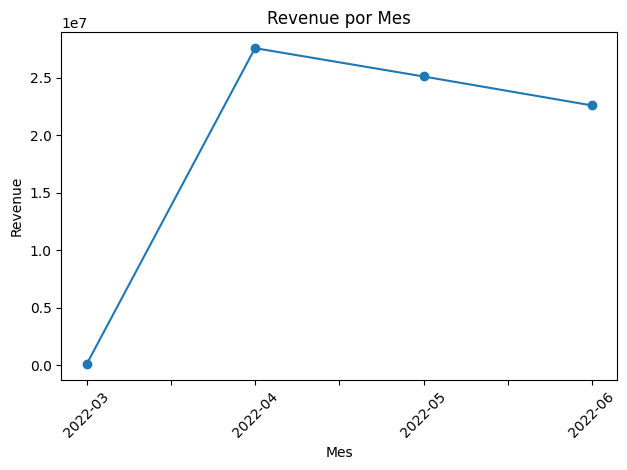

category
Set              37662424.0
kurta            20452141.0
Western Dress    10629096.0
Top               5203733.0
Ethnic Dress       760711.0
Blouse             434751.0
Bottom             140226.0
Saree              118509.0
Dupatta               915.0
Name: gross_revenue, dtype: float64

sku
J0230-SKD-M        520526.0
JNE3797-KR-L       480415.0
J0230-SKD-S        470605.0
JNE3797-KR-M       408332.0
JNE3797-KR-S       370852.0
JNE3797-KR-XL      308579.0
J0230-SKD-L        300425.0
JNE3797-KR-XS      285810.0
SET268-KR-NP-XL    282558.0
SET268-KR-NP-S     266280.0
Name: gross_revenue, dtype: float64

{'rows': 123839,
 'cols': 38,
 'revenue_total': 75402506.0,
 'orders': 115645,
 'AOV_mean': 696.2695045939332,
 'AOV_median': 635.0}

In [ ]:
summary = {}
summary["rows"] = int(len(df))
summary["cols"] = int(len(df.columns))

if "gross_revenue" in df:
    summary["revenue_total"] = float(np.nansum(df["gross_revenue"]))
else:
    summary["revenue_total"] = None

if order_id_col and "gross_revenue" in df:
    order_totals = df.groupby(order_id_col, dropna=False)["gross_revenue"].sum(min_count=1)
    summary["orders"] = int(order_totals.shape[0])
    summary["AOV_mean"] = float(order_totals.mean())
    summary["AOV_median"] = float(order_totals.median())

if "status_bucket" in df:
    display(df["status_bucket"].value_counts(dropna=False))

if "order_month" in df:
    month_rev = df.groupby("order_month", dropna=False)["gross_revenue"].sum().sort_index()
    display(month_rev.head())
    if len(month_rev):
        plt.figure()
        month_rev.plot(kind="line", marker="o")
        plt.title("Revenue por Mes")
        plt.xlabel("Mes")
        plt.ylabel("Revenue")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

if "category" in df:
    top_cat = df.groupby("category")["gross_revenue"].sum().sort_values(ascending=False).head(10)
    display(top_cat)

if "sku" in df:
    top_sku = df.groupby("sku")["gross_revenue"].sum().sort_values(ascending=False).head(10)
    display(top_sku)

summary

## Export para Tableau
Este módulo genera el dataset ya limpio y enriquecido en un CSV listo para Tableau.

Contiene:
-- Métricas: gross_revenue, order_total, aov_by_order, qty, price (si existe).
- Dimensiones tiempo: order_year, order_month, order_week, order_weekday, order_hour, is_weekend.
- Dimensiones negocio: order_id, sku, category, status_bucket, is_b2b, has_promo.
- Flags de calidad: is_negative_revenue.

Nota: aov_by_order se repite por línea a propósito. Esto simplifica visualizaciones a nivel línea sin usar LODs en Tableau.

In [9]:
df.to_csv(CLEAN_PATH, index=False)
print("Exportado:", CLEAN_PATH, df.shape)


Exportado: amazon_cleaned_for_tableau.csv (123839, 38)


### Apéndice - Diccionario de datos

| Columna | Tipo | Descripción | Ejemplo |
|---|---|---|---|
| order_id | string | ID del pedido (no fecha) | 404-0687676-7273146 |
| date / order_date | datetime | Fecha/hora del pedido | 2022-04-30 |
| sku | string | SKU del producto | JNE3797-KR-L |
| category | string | Categoría del ítem | Kurta |
| qty | number | Cantidad por línea | 1 |
| price | number | Precio unitario | 399 |
| amount | number | Total de línea si existe | 399 |
| gross_revenue | number | Revenue por línea | 399 |
| order_month | string | Periodo YYYY-MM | 2022-04 |
| status_bucket | string | Cumplimiento | fulfilled |
| aov_by_order | number | Total por pedido | 685 |
